## Molecular dynamics of an explicitly solvated small protein

For the simulations in this notebook, we will make use of the crystal structure of the Villin Headpiece subdomain [1YRF](https://www.rcsb.org/structure/1YRF). This is relatively small protein (35 residues) consisting of three alpha helices. This is a prototypical fast folding protein, see [10.1016/j.jmb.2006.03.034](https://doi.org/10.1016/j.jmb.2006.03.034) and [10.1073/pnas.0502495102](https://doi.org/10.1073/pnas.0502495102), and it is therefore a popular benchmark for protein folding molecular dynamics simulations, e.g. [10.1073/pnas.1800690115](https://doi.org/10.1073/pnas.1800690115) (force field accuracy) and [10.1109/SC.2014.9](https://doi.org/10.1109/SC.2014.9) (computational performance).



In [1]:
from sys import stdout
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *

import openmmtools

In [3]:
%matplotlib inline
import numpy as np
import mdtraj
import pandas
import matplotlib.pyplot as plt
import nglview

### Cleaning up and preparing structures before MD

The PDB file for 1YRF contains more information than we need. It holds several possible states of some residues mixed into one file and OpenMM cannot handle this. Most atoms positions are the same for all these states, but a few have an extra `A`, `B`, `C`, ... just after the atom name. The following function splits such a PDB file into multiples ones. Each of these files is suitable for starting an OpenMM simulation.

In [4]:
def split_pdb(fn_pdb):
    pos = 16
    groups = {}
    counter = 0
    
    with open(fn_pdb) as f:
        
        for line in f:
            if line.startswith("ATOM"):
                state = line[pos]
                line  = line[:pos] + " " + line[pos+1:]
                groups.setdefault(state, []).append((counter, line))
                counter += 1
                
    for key, lines_group in groups.items():
        
        if key == " ":
            continue
        lines_both = lines_group + groups[" "]
        lines_both.sort()
        with open("{}_{}.pdb".format(fn_pdb[:-4], key.lower()), "w") as f:
            for counter, line in lines_both:
                f.write(line)
                
split_pdb("1yrf.pdb")

pdb = PDBFile('1yrf_a.pdb')

### Specify forcefield and parameters of simulation

In [5]:
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

modeller = Modeller(pdb.topology, pdb.positions)
modeller.addHydrogens(forcefield)
modeller.addSolvent(forcefield, model='tip3p', padding=1*nanometer)

system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, constraints=HBonds)

temperature = 300 * kelvin
pressure    = 1 * bar
integrator  = LangevinIntegrator(temperature, 1/picosecond, 2*femtoseconds)

system.addForce(MonteCarloBarostat(pressure, temperature))

simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy(maxIterations=100)
positions = simulation.context.getState(getPositions=True).getPositions()

with open('init.pdb', 'w') as f: 
    PDBFile.writeFile(simulation.topology, positions, f)

**Exercsie**

> Which changes to the input structure can be made, for which the force field can still be applied? Try the following:
>
> - Remove an atom from the PDB file.
> - Remove an entire residue from the PDB file.
> - Use an engineered form of the Villin Headpiece, e.g. the Lys24Nle mutant (PDB 1WY3) or the Lys24Nle/Lys29Nle double mutant (PDB 2F4K).
>
> Finally, restore the input to the original one and rerun the above code cell, to have a good starting point for the next cell.
>
> With the methodology shown here, it is not be possible to define custom mutations.

In [6]:
simulation.reporters = []

simulation.reporters.append(DCDReporter('traj.dcd', 10))
simulation.reporters.append(StateDataReporter(stdout, 100, step=True,
        temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars.csv", 10, step=True, time=True,
    potentialEnergy=True, totalEnergy=True, temperature=True))
simulation.step(3000)

# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation

#"Step","Temperature (K)","Elapsed Time (s)"
100,91.97482641042086,0.00011706352233886719
200,138.5881092283947,2.278959035873413
300,172.13936105189032,4.546190977096558
400,192.45517736886958,7.695323944091797
500,219.73771891471904,10.340286016464233
600,230.8735049012794,12.798917055130005
700,246.15439676110125,15.398384809494019
800,255.9623770499601,17.859151124954224
900,257.88360172104314,20.933987140655518
1000,268.78552573635585,23.81154203414917
1100,276.35358313935336,27.533809900283813
1200,276.04395249325336,30.96226406097412
1300,285.39499569483354,33.74939012527466
1400,286.2436989199325,35.969210147857666
1500,290.9989593661533,38.537819147109985
1600,294.3190826656211,41.1073100566864
1700,295.03085701124286,43.94684195518494
1800,297.8801580191796,46.55576801300049
1900,294.26368453934776,49.27854800224304
2000,303.01451832508724,52.41354203224182
2100,299.7952227890929,55.26228976249695
2200,301.2968705568418,57.88455080986023
2300,292.95499664828947,60.32602787017

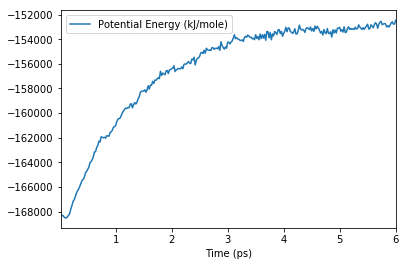

In [7]:
df = pandas.read_csv("scalars.csv")

df.plot(kind='line', x='Time (ps)', y='Potential Energy (kJ/mole)')

In [10]:
traj = mdtraj.load('traj.dcd', top='init.pdb')
view = nglview.show_mdtraj(traj)
view

NGLWidget(max_frame=299)